--- Data Loaded Successfully ---
Original Shape: (5000, 14)
Shape after cleaning outliers: (4990, 14)

--- Generating EDA Plots ---


/var/folders/jn/rsz93r615x19rmqn0pywgnhm0000gn/T/ipykernel_98131/2813193148.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churned', data=df_clean, palette='pastel')


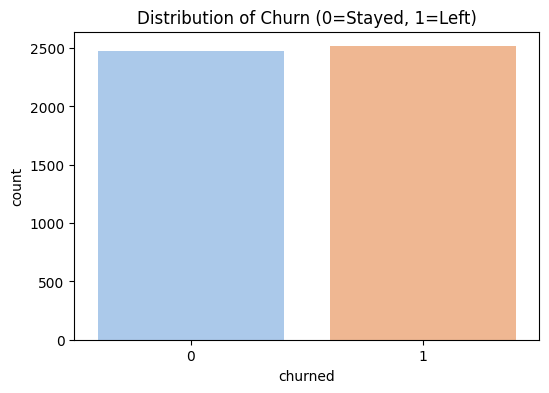

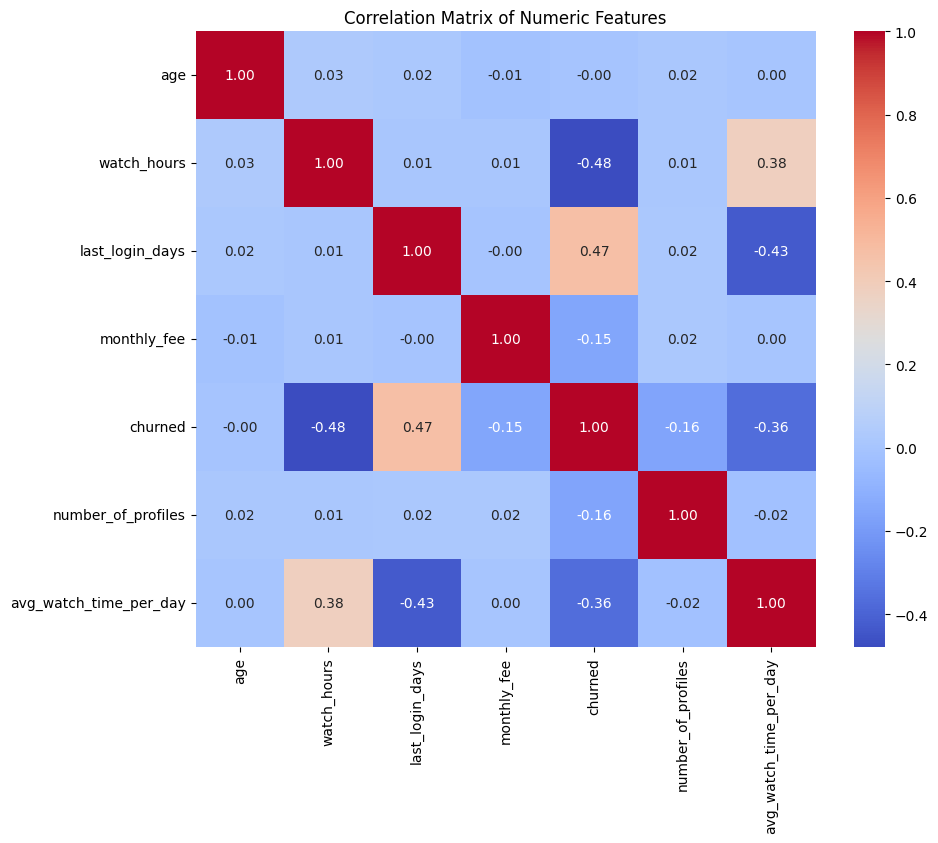


--- Running K-Means Clustering ---
Cluster Profiles (Mean Values):
               watch_hours  monthly_fee        age
Cluster_Label                                     
0                11.463060     8.990000  44.196138
1                10.994956    15.995921  30.208999
2                12.327354    16.041095  57.483577

--- Running Random Forest Classification ---

--- Final Model Results ---
✅ Model Accuracy: 97.60%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       461
           1       0.99      0.97      0.98       537

    accuracy                           0.98       998
   macro avg       0.98      0.98      0.98       998
weighted avg       0.98      0.98      0.98       998



/var/folders/jn/rsz93r615x19rmqn0pywgnhm0000gn/T/ipykernel_98131/2813193148.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10), palette='viridis')


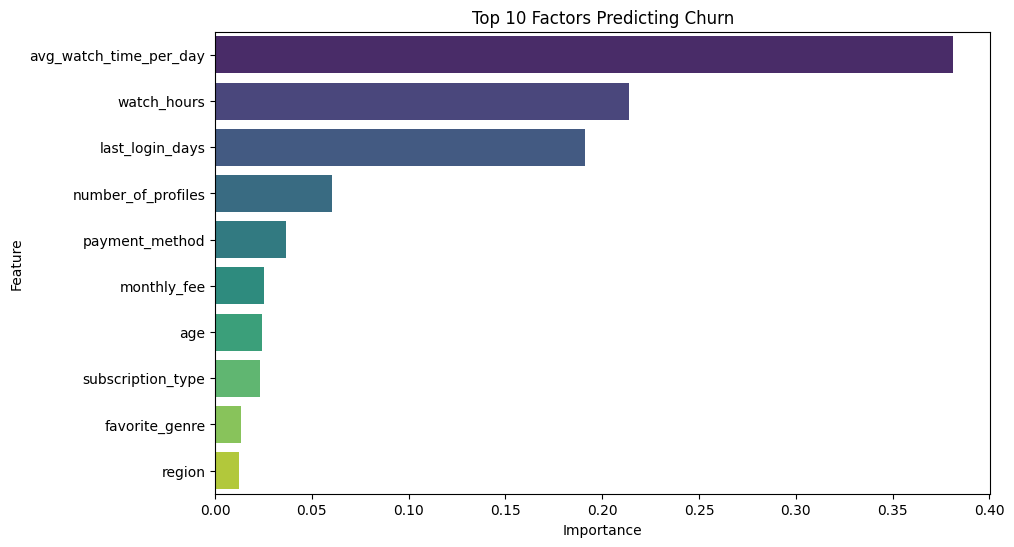

Cluster_Label
1    1689
0    1657
2    1644
Name: count, dtype: int64


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================================
# 1. DATA LOADING & CLEANING
# ==========================================
# Make sure the CSV file is in the same folder as this script
file_path = "/Users/kamyasarda/Downloads/netflix_customer_churn.csv" 
df = pd.read_csv(file_path)

print("--- Data Loaded Successfully ---")
print(f"Original Shape: {df.shape}")

# DATA CLEANING: Removing Outliers
# We found values in 'avg_watch_time_per_day' > 24 hours. This is impossible.
# We filter the data to keep only realistic values (<= 24 hours).
df_clean = df[df['avg_watch_time_per_day'] <= 24].copy()
print(f"Shape after cleaning outliers: {df_clean.shape}")

# Drop 'customer_id' as it is unique and useless for prediction
df_clean = df_clean.drop(columns=['customer_id'])

# ==========================================
# 2. EDA (Exploratory Data Analysis)
# ==========================================
print("\n--- Generating EDA Plots ---")

# Plot 1: Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='churned', data=df_clean, palette='pastel')
plt.title("Distribution of Churn (0=Stayed, 1=Left)")
plt.show()

# Plot 2: Correlation Heatmap (Professor's Requirement)
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation
numeric_df = df_clean.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# ==========================================
# 3. CLUSTERING (Unsupervised Learning)
# ==========================================
print("\n--- Running K-Means Clustering ---")

# We cluster based on usage behavior: Watch Hours, Monthly Fee, and Age
cluster_features = ['watch_hours', 'monthly_fee', 'age']
X_cluster = df_clean[cluster_features]

# Scaling is CRITICAL for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Apply K-Means with K=3 (Low, Medium, High usage groups)
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Cluster_Label'] = kmeans.fit_predict(X_scaled)

# Print the profile of each cluster
print("Cluster Profiles (Mean Values):")
print(df_clean.groupby('Cluster_Label')[cluster_features].mean())

# ==========================================
# 4. CLASSIFICATION (Random Forest)
# ==========================================
print("\n--- Running Random Forest Classification ---")

# Step A: Preprocessing (Label Encoding)
# Convert text columns (Gender, Region, etc.) into numbers
le = LabelEncoder()
categorical_cols = df_clean.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

# Step B: Define X (Features) and y (Target)
X = df_clean.drop(columns=['churned', 'Cluster_Label']) # We don't use the cluster label to predict churn
y = df_clean['churned']

# Step C: Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step D: Train the Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step E: Make Predictions
y_pred = rf_model.predict(X_test)

# ==========================================
# 5. RESULTS & EVALUATION
# ==========================================
print("\n--- Final Model Results ---")
acc = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {acc*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance Plot
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10), palette='viridis')
plt.title("Top 10 Factors Predicting Churn")
plt.show()

print(df_clean['Cluster_Label'].value_counts())

<Figure size 600x500 with 0 Axes>

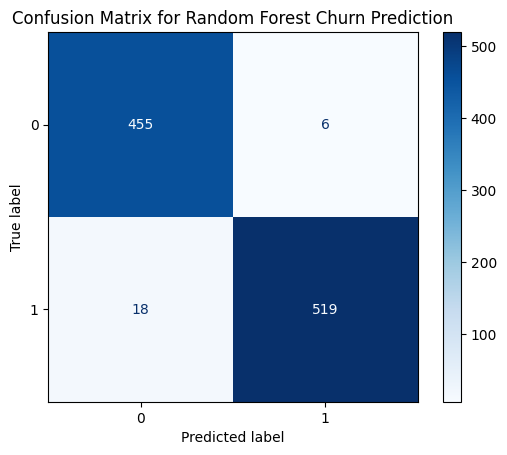

In [3]:
# ==========================================
# 6. CONFUSION MATRIX (Recommended)
# ==========================================
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix for Random Forest Churn Prediction")
plt.show()


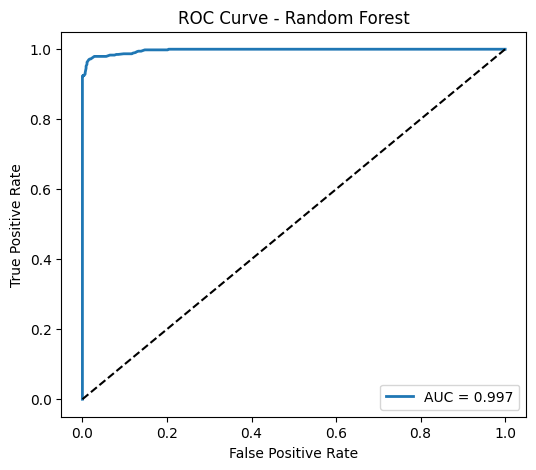

ROC-AUC Score: 0.997


In [4]:
# ==========================================
# 7. ROC CURVE & AUC SCORE (Optional but Valuable)
# ==========================================
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for class 1 (churn)
y_prob = rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')  # reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.3f}")


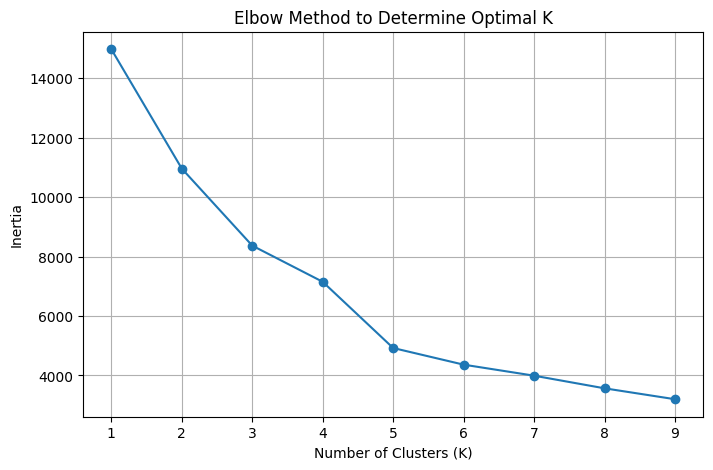

In [5]:
# ==========================================
# 8. ELBOW METHOD (Optional for Clustering)
# ==========================================
inertia_values = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia_values.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_values, marker='o')
plt.title("Elbow Method to Determine Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()
